## Setup

In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

##### Likelihood in a Mixture Model:

$$ p(x_n|\Theta) = \sum_{k=1}^{K} \, \pi_k \, p(x_n|\theta_k)$$


$$ \log p(X|\Theta) = \sum_{n=1}^{N} \, \log(\, \sum_{k=1}^{K} \, \pi_k \, p(x|\theta_k) \, )$$ 



## Truncated curves exploration

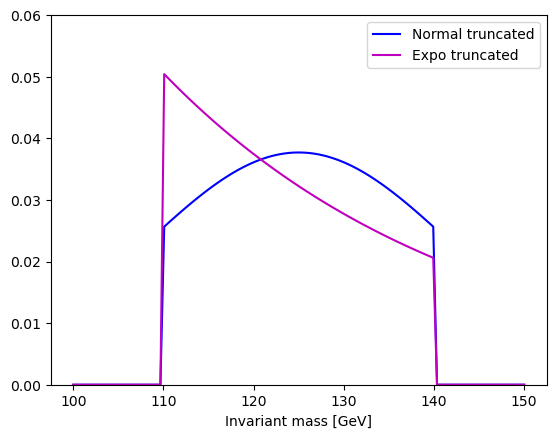

In [3]:
x = np.linspace(100,150,120)
mu = 125
sigma = 17
plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', label='Normal truncated')
b = 30
Lambda = 0.03
plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', label = 'Expo truncated')
plt.ylim(0,0.06)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

In [4]:
sum(stats.truncnorm.pdf(x,(110-125)/17,(140-125)/17,125,17))*50/120

0.9980516360413421

In [5]:
sum(stats.truncexpon.pdf(x-110,30*0.03, loc=0, scale = 1/0.03))*50/120

1.0005555373368886

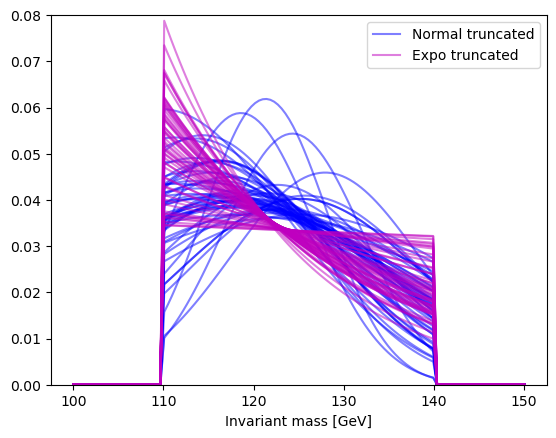

In [6]:
x = np.linspace(100,150,120)
np.random.seed(1)
for i in range(50):
    mu = np.random.normal(117,5)
    sigma = np.random.normal(16,4)
    if i==0: plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5, label='Normal truncated')
    plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5)
for j in range(50):
    b = 30
    Lambda = abs(np.random.normal(0.03,0.02))
    if j==0: plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', alpha=0.5, label = 'Expo truncated')
    plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-',  alpha=0.5)
plt.ylim(0,0.08)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

## Generate synthetic data

In [30]:
b=30
Lambda = 0.06
mu=120
sigma=7
###################
data = []
p = [0.7,0.3] # p[0]: background, p[1]: signal
np.random.seed(seed=0)
for i in range(5000):
    if np.random.binomial(1,p[1], size=1)[0] == 1: # We sample a binomial with p[1], hence it is 1 if it is signal
        data.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2))+[1])
    else:
        data.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2))+[0])
        

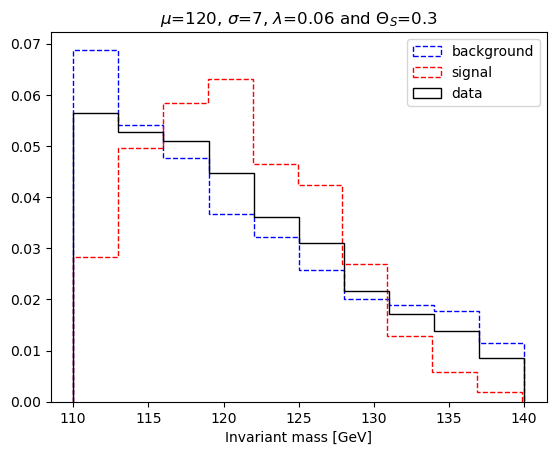

In [31]:
plt.hist([x[1] for x in data if x[2]==0], histtype='step', linestyle='dashed', color='blue', density=1, label = 'background')
plt.hist([x[1] for x in data if x[2]==1],histtype='step', linestyle='dashed', color='red',  density=1, label='signal')
plt.hist([x[1] for x in data],histtype='step', density=1, color='black', label='data')
plt.xlabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

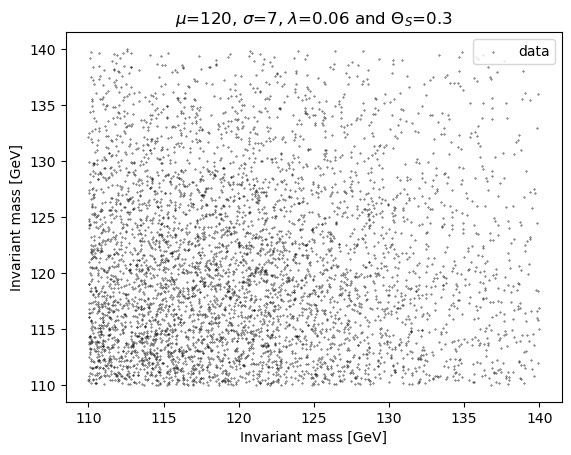

In [32]:
plt.scatter([x[0] for x in data], [x[1] for x in data], color='black', s=0.1, label='data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

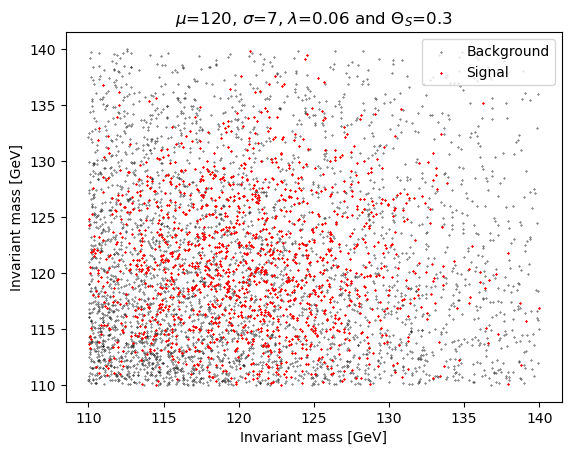

In [33]:
plt.scatter([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], color='black', s=0.1, label='Background')
plt.scatter([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], color='red', marker='x', s=0.5, label='Signal')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

## Stan inference

In [11]:
my_model = """
data {
 int <lower=0> N; // number of datapoints
 real L, U; // lower and upper limits of the observables (i.e. how to truncate the distributions)
 array[N,2] real<lower=L, upper=U> y;  // there are 2 observables per datapoint
 real mu0, sigma0, mu1, sigma1, mu2, sigma2, t1, t2;  // hyperparameters for the parameters priors
}

parameters {
  real<lower=0> mu; 
  real<lower=0> sigma;
  real<lower=0> lambda0;
  simplex[2] theta;  
}

model {
    vector[2] lp;
    mu ~ normal(mu0, sigma0);
    sigma ~ cauchy(mu1, sigma1);
    lambda0 ~ normal(mu2, sigma2);
    theta ~ dirichlet([t1,t2]);
    
   for (n in 1:N) {
     lp[1] =   normal_lpdf(y[n,1] | mu, sigma)
             - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) )             
             + normal_lpdf(y[n,2] | mu, sigma)
             - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) );
     lp[2] =   exponential_lpdf( y[n,1] - L | lambda0)             
             - exponential_lcdf( U - L | lambda0) 
             + exponential_lpdf( y[n,2] - L| lambda0)
             - exponential_lcdf( U - L | lambda0);
     target += log_mix(theta, lp);                        
     };
}
"""

In [12]:
# Define hyperparameters that determine priors
mu0 = 120
sigma0 = 6
mu1 = 8
sigma1 =5
mu2 = Lambda*0.8
sigma2 = Lambda*0.2       
t1 = 1
t2 = 1

In [13]:
passed_data = [[x[0], x[1]] for x in data]
my_data = {'N': len(passed_data), 
           'y': passed_data, # Only first 2 columns. I.e. not the class.
           'mu0': mu0,
           'sigma0': sigma0,
           'mu1':mu1,
           'sigma1': sigma1,
           'mu2': mu2,
           'sigma2': sigma2,
           't1' : t1,
           't2' : t2,
           'L' : 110.0,
           'U' : 140.0
          }

In [14]:
model = stan.build(my_model, data=my_data, random_seed=0);

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s


In file included from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/tbb/concurrent_unordered_map.h:26,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:10,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/core.hpp:53,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/sequi/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/sequi/.cache/httpstan/4.13.0/models/242gmyjy/model_242gmyjy.cpp:2:
/home/sequi/.local/lib/python3.10/site-packages/httpstan/include/tbb/internal/_concurrent_unordered_impl.h: In instantiation of ‘void tbb::interface5::internal::concurrent_unordered_base<Traits>::internal_init() [

Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.1s
Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 8.1s


Building: 8.2s, done.
Messages from stanc:
Warning in '/tmp/httpstan_zpf_apnr/model_242gmyjy.stan', line 21, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [15]:
fit = model.sample(num_chains=4, num_samples=1000, delta=0.95)


Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (302/8000)
Sampling:   5% (402/8000)
Sampling:   6% (502/8000)
Sampling:   8% (601/8000)
Sampling:   9% (701/8000)
Sampling:  10% (801/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3201/8000)
Sampling:  40% (3202/8000)
Samplin

## Analyze results

In [16]:
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,lambda0,theta.1,theta.2
draws,,,,,,,,,,,,
0,-32598.104277,0.999115,0.139575,5.0,31.0,0.0,32598.962462,118.189623,8.563014,0.061925,0.419543,0.580457
1,-32597.441920,0.993883,0.162503,2.0,7.0,0.0,32599.610710,119.741626,6.663225,0.062033,0.257705,0.742295
2,-32601.246477,0.999117,0.092052,3.0,7.0,0.0,32602.039117,117.760424,9.165796,0.066802,0.465497,0.534503
3,-32598.840914,0.889407,0.192395,4.0,31.0,0.0,32602.251675,119.120009,7.511090,0.059563,0.293238,0.706762
4,-32600.955418,0.806582,0.139575,4.0,15.0,0.0,32602.327827,116.704721,10.094578,0.059481,0.517242,0.482758
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-32597.911516,0.998894,0.192395,2.0,7.0,0.0,32601.386198,118.944144,7.839592,0.060161,0.367186,0.632814
3996,-32599.286766,0.880672,0.139575,3.0,11.0,0.0,32599.820479,118.782307,7.792991,0.064441,0.365441,0.634559
3997,-32599.597938,0.998618,0.162503,4.0,15.0,0.0,32601.456524,120.595267,7.029001,0.067195,0.259073,0.740927


In [17]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda0,0.062,0.003,0.055,0.068,0.000,0.000,1390.0,995.0,1.00
mu,118.988,1.170,116.743,120.947,0.046,0.032,729.0,879.0,1.01
sigma,7.657,1.030,5.886,9.677,0.039,0.028,732.0,1087.0,1.00
theta[0],0.339,0.080,0.202,0.484,0.003,0.002,711.0,1052.0,1.00
theta[1],0.661,0.080,0.516,0.798,0.003,0.002,711.0,1052.0,1.00


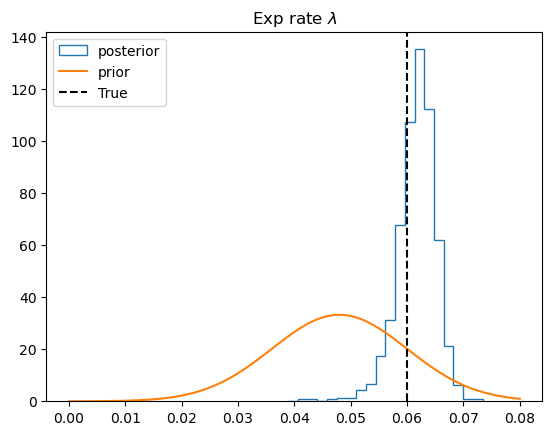

In [18]:
x=np.linspace(0,0.08,100)
plt.hist(df['lambda0'], histtype='step', density=1, bins=20, label='posterior')
plt.plot(x, stats.norm.pdf(x, mu2, sigma2), label='prior')
plt.axvline(x=Lambda, linestyle='dashed', color='black', label='True')
plt.title('Exp rate $\lambda$')
plt.legend()
plt.show()

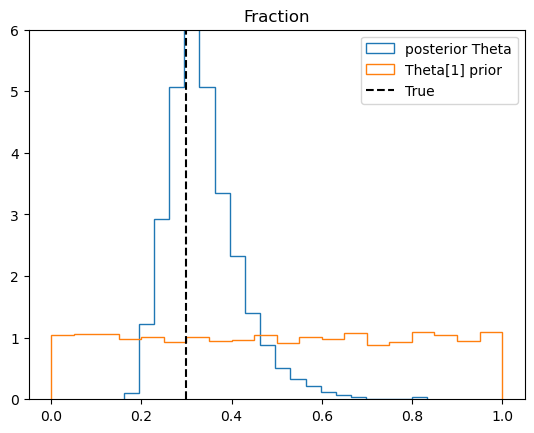

In [19]:
x=np.linspace(0,0.15,100)
tmp = np.random.dirichlet([t1,t2], size=5000)
plt.hist(df['theta.1'], histtype='step', density=1, bins=20, label='posterior Theta')
plt.hist([x[0] for x in tmp], density=1, histtype='step', bins=20, label='Theta[1] prior')
#plt.hist([x[1] for x in tmp], density=1, histtype='step', bins=20, label='Theta[2] prior')
plt.axvline(x=p[1], linestyle='dashed', color='black', label='True')
plt.ylim(0,6)
plt.title('Fraction')
plt.legend()
plt.show()

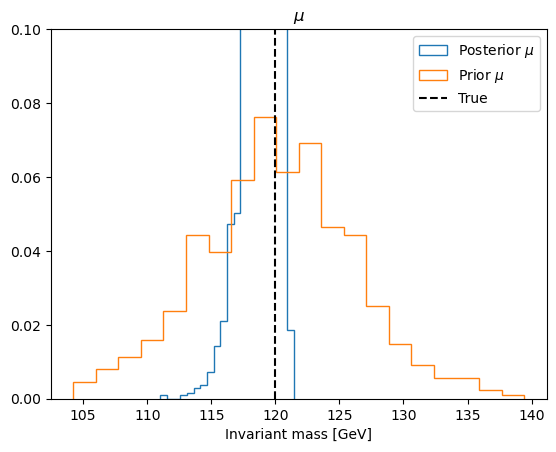

In [20]:
x=np.linspace(100,150,100)
plt.hist(df['mu'], histtype='step', density=1, bins=20, label='Posterior $\mu$')
plt.hist([x for x in np.random.normal(mu0,sigma0,size=500)], density=1, histtype='step', bins=20, label='Prior $\mu$')
plt.axvline(x=mu, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.1)
plt.title('$\mu$')
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

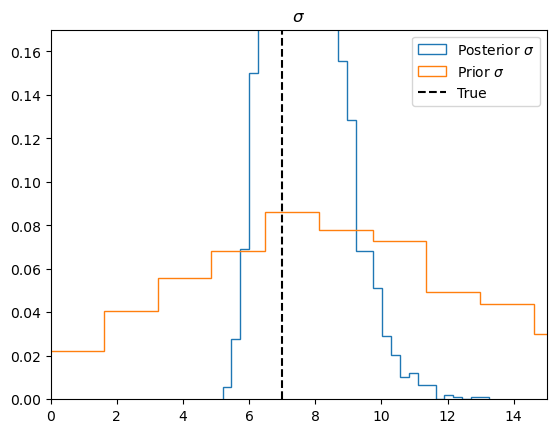

In [21]:
x=np.linspace(0,15,100)
plt.hist(df['sigma'], histtype='step', density=1, bins=30, label='Posterior $\sigma$')
plt.hist([x for x in np.random.normal(mu1,sigma1,size=1500)], density=1, histtype='step', bins=20, label='Prior $\sigma$')
plt.axvline(x=sigma, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.17)
plt.xlim(0,15)
plt.title('$\sigma$')
plt.legend()
plt.show()